In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
from time import time

from useful_functions import load_transform_split, color_scatter, scatter_predvreal, get_metric, plot_performance
from RandomSeedSearchCV import RandomSeedSearchCV, randomseed_rfr_maker

from joblib import dump,load

In [2]:
X_train,X_test,y_train,y_test,pipeline = load_transform_split(target='DROPOUT_N',
                                                              expand=False,
                                                              clean=True,
                                                              split=0.2,
                                                              return_pipeline=True,
                                                              fmt='numpy',
                                                              random_state=42)

#y_train = y_train.flatten()
#y_test  = y_test.flatten()

[[1.20600000e+03 3.03162781e+00 2.94196293e+00 3.28989079e+00
  6.35952950e-01]
 [2.28000000e+03 3.03245613e+00 2.95216524e+00 3.46228800e+00
  1.57712245e+00]
 [2.13000000e+02 3.07157927e+00 3.02273343e+00 3.59552823e+00
  1.26931453e+00]
 ...
 [2.80000000e+02 4.33133955e+00 4.38039625e+00 5.36949858e+00
  4.64416027e-01]
 [1.90200000e+03 4.33437942e+00 4.34554141e+00 5.32899589e+00
  4.36573029e-01]
 [1.80700000e+03 4.33443412e+00 4.36295411e+00 5.35165002e+00
  3.29464674e-01]]


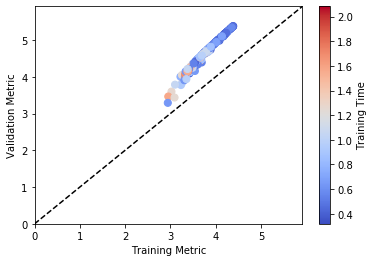

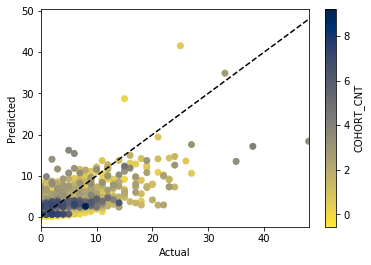

In [3]:
#CAUTION: This cell takes awhile unless you make N smaller.

#Searching through RandomForestRegressor models.
tbl = RandomSeedSearchCV(randomseed_rfr_maker,X_train,y_train,N=300,shield_seed=True,random_state=42,n_jobs=3,
                         mss_hi=100,msl_hi=50,mid_lo=0.1,mid_hi=0.6)
print(tbl)

#Get best model.
best_seed = int(tbl[0,0])
best_model = randomseed_rfr_maker(best_seed)

#Plot goodness-of-fit
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
scatter_predvreal(y_test,y_pred,colorby=X_test[:,0])

In [4]:
mse = get_metric('mean_squared_error')

print("Best RFR: Train RMSE = %.2f, Test RMSE = %.2f"%(
                               np.sqrt(mse(best_model,X_train,y_train)),
                               np.sqrt(mse(best_model,X_test,y_test)),
                               ))

Best RFR: Train RMSE = 1.40, Test RMSE = 1.48


In [17]:
#Store random search output and pickle best model.
np.savetxt("RFR_randomseedsearch.out",tbl,header='seed  cv_score  training_mse  validation_mse  training_time(s)')
dump(best_model, 'saved_models/best_RandomForestRegressor_DROPOUT_N.joblib') 

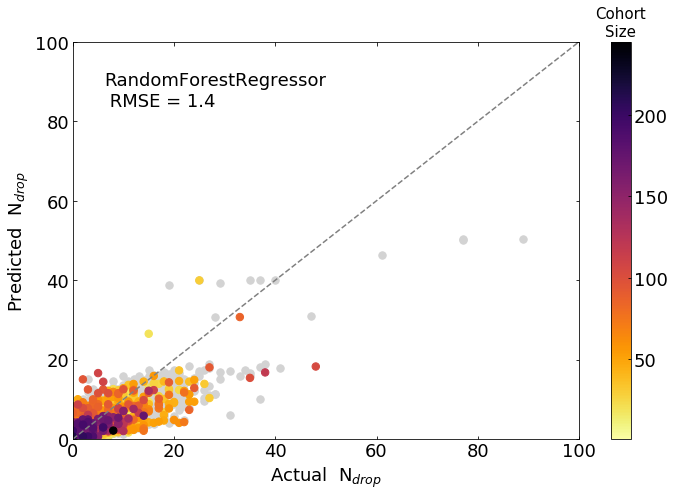

In [39]:
#Make a pretty plot for checkpoint.

plt.rcParams.update({
                     'xtick.direction':'in',
                     'xtick.top':True,
                     'xtick.bottom':True,
                     'ytick.direction':'in',
                     'ytick.right':True,
                     'ytick.left':True,
})
model = load('saved_models/best_RandomForestRegressor_DROPOUT_N.joblib')

#Load data without pipeline to get un-scaled cohort counts for colorbar.
tra,tes  = load_transform_split(target=None,
                                expand=False,
                                clean=False,
                                split=0.2,
                                return_pipeline=False,
                                fmt='pandas',
                                random_state=42)
COHORT_CNT_tes = tes['COHORT_CNT'].to_numpy()

#Plot goodness-of-fit
fig,ax=plt.subplots(figsize=(10,7))
fs = 18
model.fit(X_train,y_train)
y_pred = model.predict(X_train)
ax,cbar = color_scatter(y_train,y_pred,colorby=None,alpha=1,s=55,color='lightgray',ax=ax)
y_pred = model.predict(X_test)
cmap = plt.get_cmap('inferno_r')
ax,cbar = color_scatter(y_test,y_pred,colorby=COHORT_CNT_tes,alpha=1,s=55,cmap=cmap,ax=ax)
ma=100
ax.plot([0,ma],[0,ma],ls='--',color='gray')
ax.set_xlim(0,ma)
ax.set_ylim(0,ma)
ax.set_xlabel('Actual  N$_{drop}$',fontsize=fs)
ax.set_ylabel('Predicted  N$_{drop}$',fontsize=fs)
cbar.ax.set_title('Cohort\nSize',fontsize=15)
for tlab in ax.get_xticklabels()+ax.get_yticklabels()+cbar.ax.get_yticklabels():
    tlab.set_fontsize(fs)
calc_mse = get_metric('mean_squared_error')
rmse = np.sqrt(calc_mse(model,X_test,y_test))
ax.figure.text(0.15,0.85,"RandomForestRegressor\n RMSE = %.1f"%(rmse),fontsize=fs,horizontalalignment='left',verticalalignment='top')

plt.tight_layout()
ax.figure.savefig('figures/rfr_summary_old.png',dpi=450)

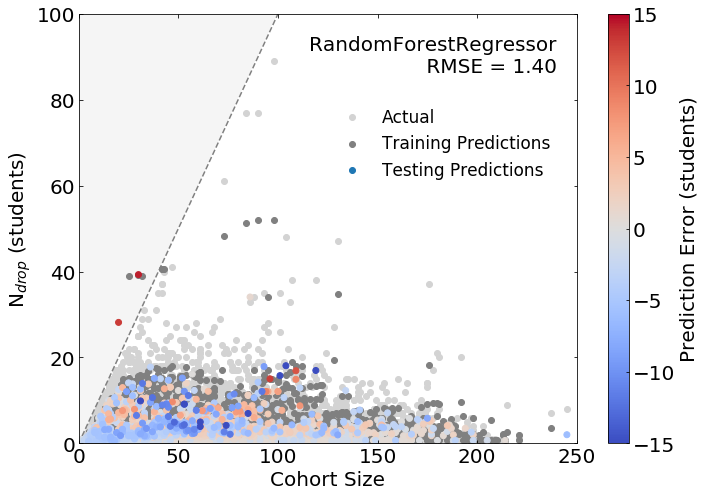

In [7]:
#Make a pretty plot for checkpoint.

plt.rcParams.update({
                     'xtick.direction':'in',
                     'xtick.top':True,
                     'xtick.bottom':True,
                     'ytick.direction':'in',
                     'ytick.right':True,
                     'ytick.left':True,
})

rfr = load('saved_models/best_RandomForestRegressor_DROPOUT_N.joblib')
#rfr = best_model
ax = plot_performance(rfr,'RandomForestRegressor',X_train,X_test,y_train,y_test)

plt.tight_layout()
ax.figure.savefig('figures/rfr_summary.png',dpi=450)

#### Try going back to DROPOUT_RATE (instead of DROPOUT_N) just to see if it works. (It doesn't)

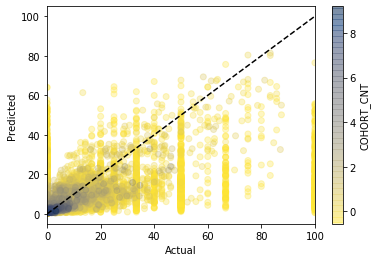

In [3]:
### Try training the best DROPOUT_N model on DROPOUT_RATE data... I wonder if it could do it.

model = load('saved_models/best_RandomForestRegressor_DROPOUT_N.joblib')

X_train,X_test,y_train,y_test,pipeline = load_transform_split(target='DROPOUT_RATE',
                                                              expand=False,
                                                              clean=True,
                                                              split=0.2,
                                                              return_pipeline=True,
                                                              fmt='numpy',
                                                              random_state=42)
y_train = y_train.flatten()
y_test  = y_test.flatten()

model.fit(X_train,y_train)

#Plot goodness-of-fit
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
scatter_predvreal(y_test,y_pred,colorby=X_test[:,0])

#Lol no it can not.